In [109]:
import datacube
%matplotlib inline
from datetime import datetime
import matplotlib
from datacube.storage import masking
from madmex.util.xarray import to_float
from madmex.wrappers import gwf_query
from madmex.util import mid_date
from madmex.recipes import RECIPES
import os
from madmex.settings import INGESTION_PATH
import xarray as xr
from datacube.api import GridWorkflow

import os
import gc
import datacube
from datacube.drivers.netcdf import write_dataset_to_netcdf
from datacube.api import GridWorkflow
import xarray as xr
import numpy as np


from madmex.util.xarray import to_float, to_int

from datetime import datetime

from madmex.util import randomword

In [2]:
dc = datacube.Datacube()

## Calcula ndbi con swir1, ndbi con swir2 y ndmi para zona de Guadalajara

In [53]:
options = {}
name_of_product = 's2_l2a_20m_mexico'
#name_of_product = 'l7_oax_50km_no_gaps_recipe_0405'
#x = (-96.93511962890624, -96.536865234375)
#y = (16.909683615558635, 17.19852235364461)
x = (-103.612060546875, -103.12042236328125)
y = (20.589080994085194, 20.94604992010052)
options['lat'] = y
options['long'] = x
options['region'] = None
options['begin'] = "2018-04-1"
options['end'] = "2018-05-1"

In [47]:
options['name'] = 's1_2_20m_resampled_10m_001'
center_dt = mid_date(datetime.strptime(options['begin'],'%Y-%m-%d'), datetime.strptime(options['end'], '%Y-%m-%d'))
path = os.path.join(INGESTION_PATH, 'recipes', options['name'])

In [54]:
gwf_kwargs = { k: options[k] for k in ['lat', 'long', 'region', 'begin', 'end']}
gwf_kwargs.update(product=name_of_product)
tile = gwf_query(**gwf_kwargs)

In [101]:
list(tile)

[((28, -30), Tile<sources=<xarray.DataArray (time: 6)>
  array([(Dataset <id=cf7ece03-9af6-41f8-bb06-bdf61b666dbd type=s2_l2a_20m_mexico location=s3:///shared_volume/datacube/datacube_ingest/s2_l2a_20m/mexico/s2_l2a_20m_28_-30_20180403173046000000>,),
         (Dataset <id=30618780-e8a4-44d5-b8cc-498fac4b8a2b type=s2_l2a_20m_mexico location=s3:///shared_volume/datacube/datacube_ingest/s2_l2a_20m/mexico/s2_l2a_20m_28_-30_20180408173539000000>,),
         (Dataset <id=72d98fb1-3da2-456e-9ce4-18757dc0ba9e type=s2_l2a_20m_mexico location=s3:///shared_volume/datacube/datacube_ingest/s2_l2a_20m/mexico/s2_l2a_20m_28_-30_20180413172714000000>,),
         (Dataset <id=1891ec52-1c20-4925-a15c-1a1d47157e04 type=s2_l2a_20m_mexico location=s3:///shared_volume/datacube/datacube_ingest/s2_l2a_20m/mexico/s2_l2a_20m_28_-30_20180418173518000000>,),
         (Dataset <id=14a78b12-eca1-4a87-82e9-0b2838c1d084 type=s2_l2a_20m_mexico location=s3:///shared_volume/datacube/datacube_ingest/s2_l2a_20m/mexico/s2_

In [120]:
        crs = list(tile)[0][1].geobox.crs
        #center_dt = center_dt.strftime("%Y-%m-%d")
        nc_filename = os.path.join(path, 's1-2_10m_001_%d_%d_%s.nc' % (list(tile)[0][0][0], list(tile)[0][0][1], center_dt))
        # Load Landsat sr
        if os.path.isfile(nc_filename):
            #logger.warning('%s already exists. Returning filename for database indexing', nc_filename)
            raise Error('%s already exists. Returning filename for database indexing', nc_filename)
        sr_0 = xr.merge([GridWorkflow.load(x[1], dask_chunks={'x': 3000, 'y': 3000}) for x in list(tile)])
        sr_0.attrs['geobox'] = list(tile)[0][1].geobox
        sr_0 = sr_0.apply(func=to_float, keep_attrs=True)
        #load s1 data
        dc = datacube.Datacube(app = 's1-2_10m_001_%s' % randomword(5))
        sar = dc.load(product='s1_snappy_vh_vv_mexico', like=sr_0, time=(datetime(2015, 1, 1), datetime(2015, 12, 31)), dask_chunks={'x': 3000, 'y': 3000})
        sar = sar.apply(func=to_float, keep_attrs=True)
        sar.attrs['geobox'] = list(tile)[0][1].geobox
        # Reduce time dimension of sar variables
        sar_mean = sar.mean('time', keep_attrs=True, skipna=True)
        sar_mean.rename({'polarisation_VH': 'vh',
                         'polarisation_VV': 'vv'}, inplace=True)
        # Load terrain metrics using same spatial parameters than sr
        terrain = dc.load(product='srtm_cgiar_mexico', like=sr_0,
                          time=(datetime(1970, 1, 1), datetime(2018, 1, 1)),
                          dask_chunks={'x': 3000, 'y': 3000})
        dc.close()
        # Keep clear pixels (2: Dark features, 4: Vegetation, 5: Not vegetated,
        # 6: Water, 7: Unclassified, 8: Cloud medium probability, 11: Snow/Ice)
        sr_1 = sr_0.where(sr_0.pixel_qa.isin([2,4,5,6,7,8,11]))
        sr_1 = sr_1.drop('pixel_qa')
        # Compute ndvi
        sr_1['ndvi'] = ((sr_1.nir - sr_1.red) / (sr_1.nir + sr_1.red)) * 10000
        sr_1['ndvi'].attrs['nodata'] = 0
        # Compute ndbi
        sr_1['ndbil'] = ((sr_1.swir1 - sr_1.nir) / (sr_1.swir1 + sr_1.nir)) * 10000
        sr_1['ndbil'].attrs['nodata'] = 0
        sr_1['ndbi'] =  ((sr_1.swir2 - sr_1.nir) / (sr_1.swir2 + sr_1.nir)) * 10000
        sr_1['ndbi'].attrs['nodata'] = 0
        # Compute ndmi
        sr_1['ndmi'] = ((sr_1.nir - sr_1.swir1) / (sr_1.nir + sr_1.swir1)) * 10000
        sr_1['ndmi'].attrs['nodata'] = 0
        
        sr_mean = sr_1.mean('time', keep_attrs=True, skipna=True)

In [121]:
sr_mean

<xarray.Dataset>
Dimensions:  (x: 5002, y: 5002)
Coordinates:
  * x        (x) float64 2.328e+06 2.328e+06 2.328e+06 ... 2.428e+06 2.428e+06
  * y        (y) float64 9.261e+05 9.262e+05 9.262e+05 ... 1.026e+06 1.026e+06
Data variables:
    blue     (y, x) float64 dask.array<shape=(5002, 5002), chunksize=(5002, 5002)>
    green    (y, x) float64 dask.array<shape=(5002, 5002), chunksize=(5002, 5002)>
    red      (y, x) float64 dask.array<shape=(5002, 5002), chunksize=(5002, 5002)>
    re1      (y, x) float64 dask.array<shape=(5002, 5002), chunksize=(5002, 5002)>
    re2      (y, x) float64 dask.array<shape=(5002, 5002), chunksize=(5002, 5002)>
    re3      (y, x) float64 dask.array<shape=(5002, 5002), chunksize=(5002, 5002)>
    nir      (y, x) float64 dask.array<shape=(5002, 5002), chunksize=(5002, 5002)>
    swir1    (y, x) float64 dask.array<shape=(5002, 5002), chunksize=(5002, 5002)>
    swir2    (y, x) float64 dask.array<shape=(5002, 5002), chunksize=(5002, 5002)>
    ndvi     (y, 

In [112]:
matplotlib.rcParams['figure.figsize'] = [12, 8]

### ndbi con swir2 de zona de Guadalajara

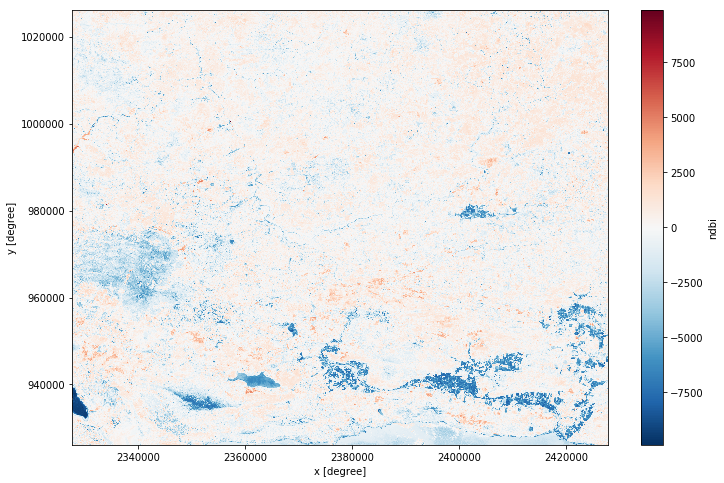

In [115]:
sr_mean.ndbi.plot()

### ndbi con swir1 de zona de Guadalajara

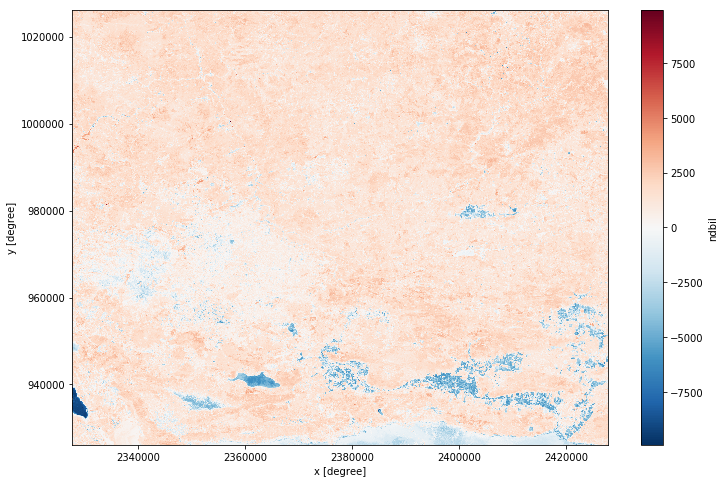

In [117]:
sr_mean.ndbil.plot()

### ndmi de zona de Guadalajara

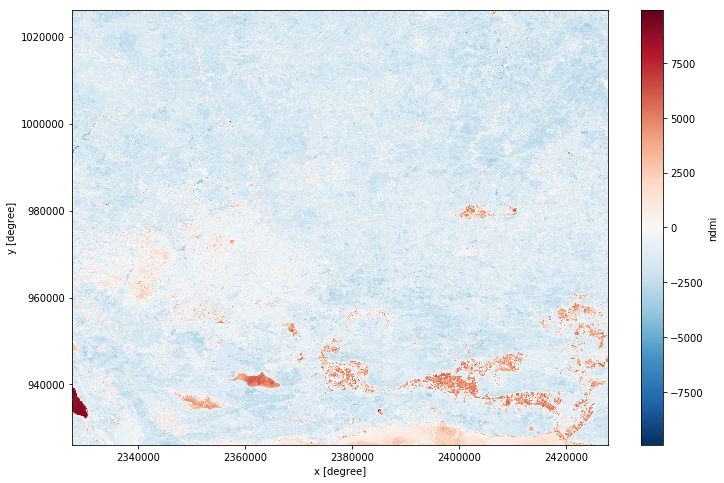

In [123]:
sr_mean.ndmi.plot()

## ndvi, ndbi con swir1, ndbi con swir2 y ndmi de zona de Ciudad de Oaxaca

In [213]:
options = {}
name_of_product = 'ls7_espa_mexico_50km'
#name_of_product = 'l7_oax_50km_no_gaps_recipe_0405'
x = (-96.80191040039062, -96.6741943359375)
y = (17.01739387453587, 17.14079039331665)
options['lat'] = y
options['long'] = x
options['region'] = None
options['begin'] = "2004-01-1"
options['end'] = "2005-12-1"

In [214]:
options['name'] = 'landsat_madmex_002'
center_dt = mid_date(datetime.strptime(options['begin'],'%Y-%m-%d'), datetime.strptime(options['end'], '%Y-%m-%d'))
path = os.path.join(INGESTION_PATH, 'recipes', options['name'])

In [215]:
gwf_kwargs = { k: options[k] for k in ['lat', 'long', 'region', 'begin', 'end']}
gwf_kwargs.update(product=name_of_product)
tile = gwf_query(**gwf_kwargs)

In [163]:
sr_0.pixel_qa

<xarray.DataArray 'pixel_qa' (time: 1, y: 3334, x: 1667)>
dask.array<shape=(1, 3334, 1667), dtype=float64, chunksize=(1, 3334, 1667)>
Coordinates:
  * y        (y) float64 5.264e+05 5.264e+05 5.264e+05 ... 6.263e+05 6.263e+05
  * time     (time) datetime64[ns] 2004-02-06T16:43:19
  * x        (x) float64 3.028e+06 3.028e+06 3.028e+06 ... 3.078e+06 3.078e+06
Attributes:
    units:             bit_index
    nodata:            1
    flags_definition:  {'fill': {'bits': [0], 'values': {'0': False, '1': Tru...
    crs:               PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHER...

In [216]:
lista_iter = list(tile)

In [217]:
[lista_iter[x][0] for x in range(0,len(lista_iter))]

[(41, -37), (41, -38)]

In [249]:
var= list_iter[0]

In [268]:
var[1].geobox.crs.dimensions

('y', 'x')

In [251]:
sr_0 = GridWorkflow.load(var[1], dask_chunks={'x': 1667, 'y': 1667})

In [242]:
sr_0

<xarray.Dataset>
Dimensions:   (time: 4, x: 1667, y: 1667)
Coordinates:
  * time      (time) datetime64[ns] 2004-02-06T16:43:19 ... 2005-04-29T16:43:48
  * y         (y) float64 5.763e+05 5.763e+05 5.763e+05 ... 5.264e+05 5.264e+05
  * x         (x) float64 3.028e+06 3.028e+06 3.028e+06 ... 3.078e+06 3.078e+06
Data variables:
    blue      (time, y, x) int16 dask.array<shape=(4, 1667, 1667), chunksize=(4, 1667, 1667)>
    green     (time, y, x) int16 dask.array<shape=(4, 1667, 1667), chunksize=(4, 1667, 1667)>
    red       (time, y, x) int16 dask.array<shape=(4, 1667, 1667), chunksize=(4, 1667, 1667)>
    nir       (time, y, x) int16 dask.array<shape=(4, 1667, 1667), chunksize=(4, 1667, 1667)>
    swir1     (time, y, x) int16 dask.array<shape=(4, 1667, 1667), chunksize=(4, 1667, 1667)>
    swir2     (time, y, x) int16 dask.array<shape=(4, 1667, 1667), chunksize=(4, 1667, 1667)>
    pixel_qa  (time, y, x) uint16 dask.array<shape=(4, 1667, 1667), chunksize=(4, 1667, 1667)>
Attributes:
 

In [252]:
clear = masking.make_mask(sr_0.pixel_qa, cloud=False, cloud_shadow=False,snow=False)

In [253]:
        sr_1 = sr_0.where(clear)
        #sr_1 = sr_0
        sr_1 = sr_1.drop('pixel_qa')
        sr_1 = sr_1.apply(func=to_float, keep_attrs=True)
        # Compute ndvi
        sr_1['ndvi'] = ((sr_1.nir - sr_1.red) / (sr_1.nir + sr_1.red)) * 10000
        sr_1['ndvi'].attrs['nodata'] = -9999
        # Compute ndbi
        sr_1['ndbil'] = ((sr_1.swir1 - sr_1.nir) / (sr_1.swir1 + sr_1.nir)) * 10000
        sr_1['ndbil'].attrs['nodata'] = -9999
        sr_1['ndbi'] =  ((sr_1.swir2 - sr_1.nir) / (sr_1.swir2 + sr_1.nir)) * 10000
        sr_1['ndbi'].attrs['nodata'] = -9999
        # Compute ndmi
        sr_1['ndmi'] = ((sr_1.nir - sr_1.swir1) / (sr_1.nir + sr_1.swir1)) * 10000
        sr_1['ndmi'].attrs['nodata'] = -9999
        
        sr_mean = sr_1.mean('time', keep_attrs=True, skipna=True)

### ndbi con swir1 para zona de Ciudad de Oaxaca

In [200]:
matplotlib.rcParams['figure.figsize'] = [12, 8]

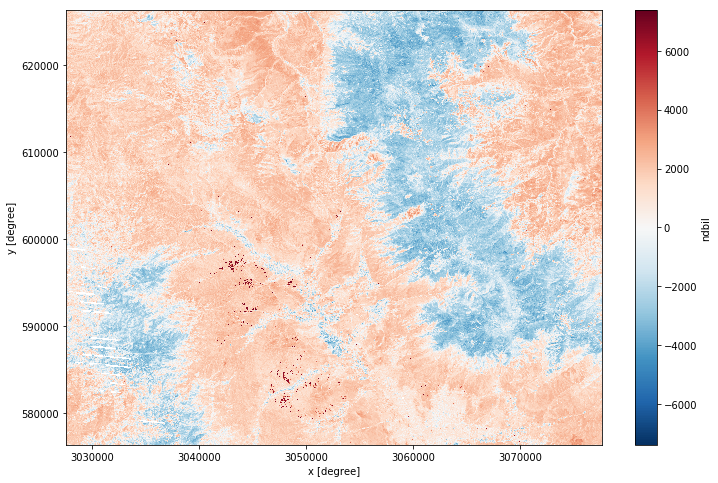

In [254]:
sr_mean.ndbil.plot()

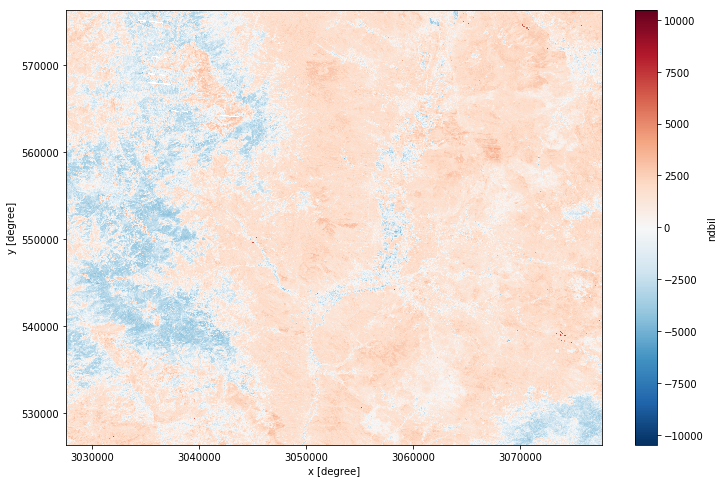

In [245]:
sr_mean.ndbil.plot()

### ndvi para zona de Ciudad de Oaxaca

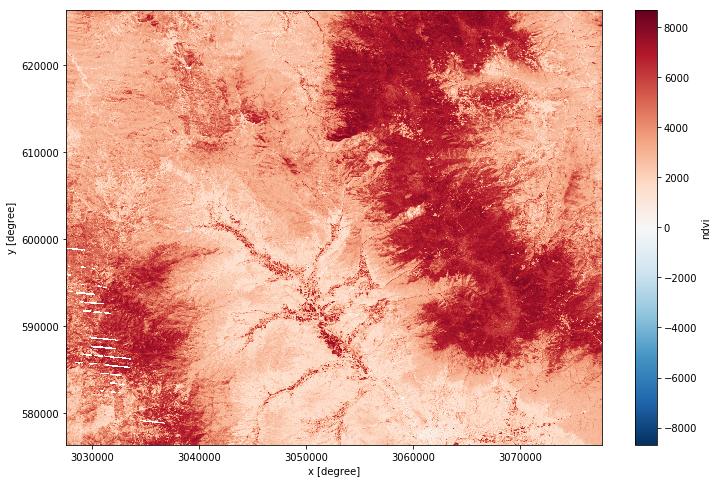

In [255]:
sr_mean.ndvi.plot()

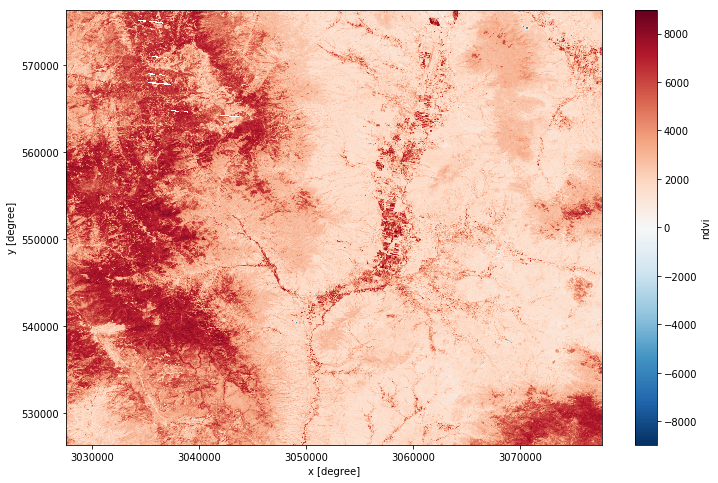

In [246]:
sr_mean.ndvi.plot()

### ndbi con swir2 para zona de Ciudad de Oaxaca

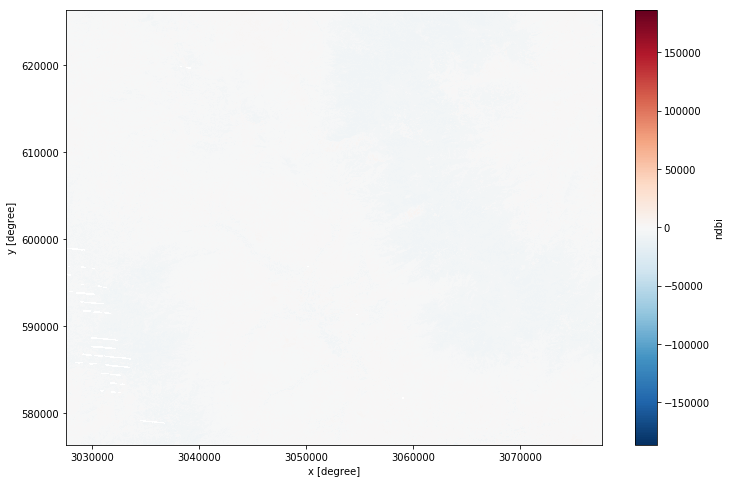

In [256]:
sr_mean.ndbi.plot()

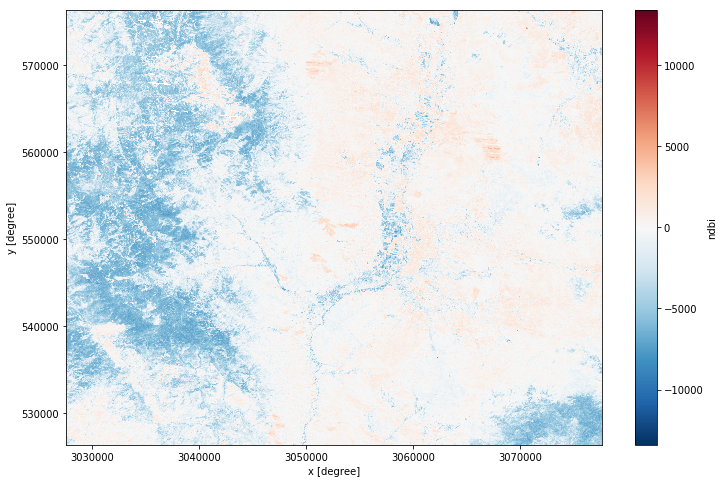

In [247]:
sr_mean.ndbi.plot()

### ndmi para zona de Ciudad de Oaxaca

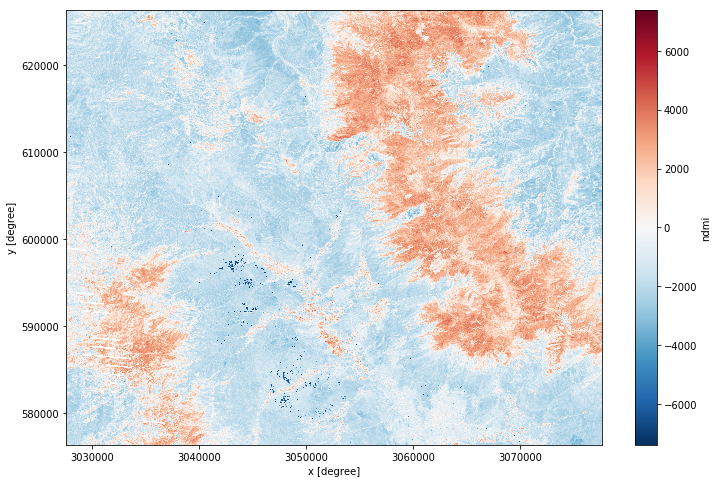

In [257]:
sr_mean.ndmi.plot()

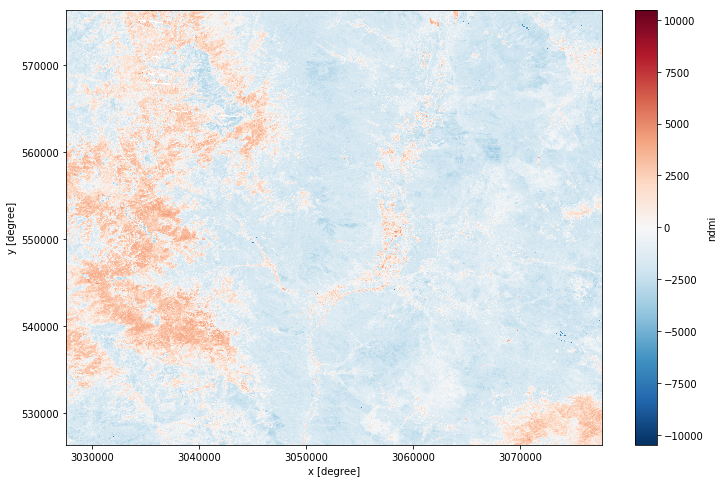

In [248]:
sr_mean.ndmi.plot()